### <b>Install the required libraries</b>

In [1]:
# Install the transformers library (Allows importing models from Hugging Face)
!pip install transformers
!pip install datasets 

### <b>Import necessary libraries</b>

In [2]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [3]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 0
GPU Memory Cached: 0


### <b>Load the model from Hugging Face's model hub</b>

In [4]:
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BigBirdConfig, AutoConfig, AutoModel

In [5]:
from transformers import AutoModel, AutoTokenizer, BigBirdConfig

model_path = "snunlp/KR-Medium"
model = AutoModel.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=False)

text = "한국어 KR-BERT 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
output = model(**encoded_input)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
# Print the values of the final hidden state
print(output[0])

# Print the shape of the final hidden state
print(output[0].shape)

tensor([[[ 0.3643,  0.6459, -0.2313,  ...,  0.6451, -0.1159,  0.3841],
         [-0.0726,  1.3123,  0.5474,  ...,  1.5355,  0.4892,  0.2628],
         [-0.2217,  1.5919, -0.4332,  ...,  0.1309, -0.0770,  0.3442],
         ...,
         [-0.6567,  0.5202, -0.1853,  ...,  0.4653,  0.0383,  0.7940],
         [-0.0108,  0.5530, -0.1801,  ...,  0.4510, -0.4076,  0.3430],
         [ 0.1201,  0.7531, -0.3095,  ...,  0.6505,  0.5646,  0.0246]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 16, 768])


### <b>Set hyperparameters for the experiment</b>

In [7]:
from types import SimpleNamespace

# Create a configuration object to store hyperparameters and other settings
config = SimpleNamespace()

config.task = "krbert_bias"
config.dataset = "KoMultiText"

config.cache_dir = "krbert_bias_cache" # Temporary directory for current task assets like vocabulary
config.output_dir = "krbert_bias_output" # Directory where final models and results will be saved

config.use_tpu = False
config.model_name_or_path = model_path 
config.data_dir = "./" # The input data dir 

config.train_file = "train_dataset.csv" 
config.predict_file = "test_dataset.csv" 

config.max_seq_length = 512 # Maximum sequence length
config.train_batch_size = 8 # Batch size for training
config.eval_batch_size = 4 # Batch size for evaluation

config.learning_rate = 3e-6 # The initial learning rate for Adam
config.num_train_epochs = 20 # Total number of training epochs to perform

config.gradient_accumulation_steps = 4 # Number of updates steps to accumulate before performing a backward/update pass.
config.threads = 4
config.seed = 42 

config.device_num = 0 # Device number (changable for multi-GPU setups)

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

### <b>Preprocessing the training dataset</b>
* Instead of tokenizing the training text every time, we preprocess and <b>save all tokenized results before starting the model training</b>.
    * This approach significantly speeds up the process.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, do_lower_case=False, cache_dir=config.cache_dir)

In [9]:
def train_split(config, texts, labels, is_train):
    
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
        
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    
    df = pd.read_csv(data_file)
    
    # Convert columns to lists for processing
    genders = df["gender"].astype(int).values.tolist()
    politics = df["politics"].astype(int).values.tolist()
    nations = df["nation"].astype(int).values.tolist()
    races = df["race"].astype(int).values.tolist()
    regions = df["region"].astype(int).values.tolist()
    generations= df["generation"].astype(int).values.tolist()
    social_clss = df["social hierarchy"].astype(int).values.tolist()
    appearences = df["appearance"].astype(int).values.tolist()
    others = df["others"].astype(int).values.tolist()
    
    # Create a combined label list
    labels = []
    for i in range(len(genders)):
        gender = genders[i] 
        politic = politics[i] 
        nation = nations[i]
        race = races[i]
        region = regions[i]
        generation = generations[i]
        social_cls = social_clss[i]
        appearence = appearences[i]
        other = others[i]
        labels.append([gender, politic, nation, race, region, generation, social_cls, appearence, other])
        
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train) # Split the data
    
    return texts, labels

In [10]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"

    # Construct the file name for the tokenized dataset
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)

    # Tokenize the dataset and write to the file
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "gender": int(label[0]),
                "politic": int(label[1]), 
                "nation" : int(label[2]),
                "race" : int(label[3]),
                "region" : int(label[4]),
                "generation" : int(label[5]),
                "social_cls" : int(label[6]),
                "appearence" : int(label[7]),
                "other": int(label[8]),
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [11]:
if config.do_train:
    # Preprocess the training dataset
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)

# Preprocess the evaluation dataset (evaluation is equivalent to 'dev' or 'validation')
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./train_dataset.csv_KoMultiText_snunlp_KR-Medium_512_train_dataset.txt
30688 features processed from ./train_dataset.csv
dataset_file: ./test_dataset.csv_KoMultiText_snunlp_KR-Medium_512_dev_dataset.txt
400 features processed from ./test_dataset.csv


### <b>Initialize the data loader</b>

In [12]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        # If dataset has a set epoch method, set the manual seed for reproducibility
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Wait to have a full batch before yielding elements.
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []
        
        # Pad the last batch if it's smaller than the batch size
        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [13]:
def collate_fn(features):
    
    # Extracting individual features from samples
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    gender = [sample["gender"] for sample in features]
    politic = [sample["politic"] for sample in features]
    nation = [sample["nation"] for sample in features]
    race = [sample["race"] for sample in features]
    region = [sample["region"] for sample in features]
    generation = [sample["generation"] for sample in features]
    social_cls = [sample["social_cls"] for sample in features]
    appearence = [sample["appearence"] for sample in features]
    other = [sample["other"] for sample in features]
    
    # Convert lists to tensors
    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    gender = torch.tensor(np.array(gender).astype(np.int64), dtype=torch.float)
    politic = torch.tensor(np.array(politic).astype(np.int64), dtype=torch.float)
    nation = torch.tensor(np.array(nation).astype(np.int64), dtype=torch.float)
    race = torch.tensor(np.array(race).astype(np.int64), dtype=torch.float)
    region = torch.tensor(np.array(region).astype(np.int64), dtype=torch.float)
    generation = torch.tensor(np.array(generation).astype(np.int64), dtype=torch.float)
    social_cls = torch.tensor(np.array(social_cls).astype(np.int64), dtype=torch.float)
    appearence = torch.tensor(np.array(appearence).astype(np.int64), dtype=torch.float)
    other = torch.tensor(np.array(other).astype(np.int64), dtype=torch.float)
    
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels = {
        "gender" : gender,
        "politic": politic,
        "nation" :nation, 
        "race" : race,
        "region" : region,
        "generation" : generation,
        "social_cls" : social_cls,
        "appearence" : appearence,
        "other" : other,
    }
    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-f375c693317dac6c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/30688 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-779a7ae82e924b53/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### <b>Define the text classification model</b>

In [14]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  # (전처리된) 학습할 데이터 세트의 경로 설정
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=5)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        
        self.activation = nn.ReLU()
        
        # Initialize multiple classifiers (linear layers) for multi-label
        self.classifiers = nn.ModuleList([nn.Linear(768, size) for size in [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        # Remove unnecessary keys from the tokenizer's init_kwargs
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): 
        # Specify parameters that should not undergo weight decay during training
        no_decay = ["bias", "LayerNorm.weight"]
        # Group model parameters based on whether they should have weight decay or not
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        # If no warmup is needed, return None
        if config.warmup_proportion == 0.0:
            return None
        
        # Calculate the total number of training steps
        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs
        
        # Define the learning rate scheduler with a linear warmup phase
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs) # Get the model's hidden states
        # Extract [CLS] token from the last layer
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        
        # Get outputs for each task using the respective classifier
        outputs = [classifier(cls_token_embeddings) for classifier in self.classifiers]

        return outputs
    

    def eval_step(self, inputs, labels, outputs):

        label_keys = ["gender", "politic", "nation", "race", "region", "generation", "social_cls", "appearence", "other"]
        results = {}
        threshold = 0.5

        for idx, key in enumerate(label_keys):
            logits = outputs[idx].detach().cpu()
            actual_labels = self.tensor_to_list(labels[key])
            predictions = self.tensor_to_list((torch.sigmoid(logits) > threshold).int())

            results[f"results_{idx+1}"] = [{
                "prediction": prediction,
                "label": label,
                "prob": torch.sigmoid(prob).item()
            } for prediction, label, prob in zip(predictions, actual_labels, logits)]

        return results
    
    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [15]:
# Set the random seed for reproducibility in both numpy and PyTorch
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Calculate the running average of the loss using a decay factor
def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

### <b>Define the functions for training and evaluation</b>

In [16]:
from functools import partial
import sklearn.metrics as sklearn_metrics
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

category_map = {
    1: "gender",
    2: "politic",
    3: "nation",
    4: "race",
    5: "region",
    6: "generation",
    7: "social hierarchy",
    8: "appearence",
    9: "other"
}

# for binary-classification
binary_metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "precision": sklearn_metrics.precision_score, # TP / (TP + FP)
    "recall": sklearn_metrics.recall_score, # recall = sensitivity (민감도)
    "f1": sklearn_metrics.f1_score,
    "matthews_corrcoef": sklearn_metrics.matthews_corrcoef,
}

# Function to calculate the area under the Precision-Recall curve.
def calculate_pr_auc(labels, prob):
    precision, recall, _ = precision_recall_curve(labels, prob)
    return auc(recall, precision)

# General function to plot either the ROC or Precision-Recall curve for multiple categories.
def plot_curve(labels_list, probs_list, category_names, curve_type="auroc"):
    plt.figure(figsize=(10, 6))
    for labels, probs, category_name in zip(labels_list, probs_list, category_names):
        if curve_type == "auroc":
            x, y, _ = roc_curve(labels, probs)
            metric = auc(x, y)
            xlabel, ylabel, title = 'False Positive Rate', 'True Positive Rate', 'ROC Curves for Bias Labels'
        else:
            x, y, _ = precision_recall_curve(labels, probs)
            metric = auc(y, x)
            xlabel, ylabel, title = 'Recall', 'Precision', 'Precision-Recall Curves for Bias Labels'
        
        plt.plot(x, y, lw=2, label=f'{category_name} (AUC = {metric:.2f})')

    if curve_type == "auroc":
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=19)
    plt.legend(loc='lower right' if curve_type == "auroc" else 'lower left', fontsize=14)
    plt.show()


# Evaluate the performance of the model based on various metrics    
def eval_cls(all_results, all_probs, **kwargs):
    
    results_dict = {}
    category_names = []
    
    labels_list = []  
    probs_list = []   
    
    for i in range(9):
        results_i = all_results[i]
        probs_i = all_probs[i]

        predictions = np.array([result["prediction"] for result in results_i])
        labels = np.array([result["label"] for result in results_i])

        y_scores = np.array([prob[1] if prob.shape[0] > 1 else prob[0] for prob in probs_i])

        labels_list.append(labels)
        probs_list.append(y_scores)

        metric_funcs = binary_metrics
        results = {metric: round(f(labels, predictions) * 100, 2) for metric, f in metric_funcs.items()}  # This line initializes the 'results' dictionary.

        results["pr_auc"] = calculate_pr_auc(labels, y_scores)
        results["roc_auc"] = sklearn_metrics.roc_auc_score(labels, y_scores)
        results_dict[f"pr_auc_{i+1}"] = results["pr_auc"]
        results_dict[f"roc_auc{i+1}"] = results["roc_auc"]

        category_name = category_map.get(i+1, f"Category {i+1}")
        category_names.append(category_name)

        results_dict[f"results_{i+1}"] = results
        
    # Plot the ROC and PRROC curves for all bias tasks
    plot_curve(labels_list, probs_list, category_names)
    plot_curve(labels_list, probs_list, category_names, curve_type="prroc")
    
    return results_dict

In [17]:
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)

    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()
        
    # ProgressBar setup
    is_master = True
    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrections = [0] * 9
    total = 0
    
    for i, (inputs, labels) in pbar:
        # Move tensors to device
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
        labels = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in labels.items()}

        outputs = model(inputs)

        threshold = 0.5
        weights_bias = [1, 10.0, 20.0]
        weights_final = [1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]
        total += outputs[0].shape[0]  # batch_size
        
        label_keys = ["gender", "politic", "nation", "race", "region", "generation", "social_cls", "appearence", "other"]

        # Define loss functions
        weight1 = torch.tensor([10.0]).to(device)
        weight2 = torch.tensor([30.0]).to(device)
        loss_with_w1 = nn.BCEWithLogitsLoss(pos_weight=weight1)
        loss_with_w2 = nn.BCEWithLogitsLoss(pos_weight=weight2)
        
        total_loss = 0
        corrections = []

        for idx, key in enumerate(label_keys):
            output = outputs[idx].squeeze(1)
            label = labels[key]
            predicted = torch.sigmoid(output) >= threshold
            correct = predicted.eq(label).sum().item()
            corrections.append(correct)

            # Loss computation
            if idx == 0:
                loss = loss_with_w1(output, label)
            else:
                loss = loss_with_w2(output, label)
            total_loss += weights_final[idx] * loss

        avg_loss = cal_running_avg_loss(total_loss.item(), avg_loss)
        total_loss /= config.gradient_accumulation_steps

        if is_train:
            total_loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)

        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )

    return {
        "loss": avg_loss,
        "result": results,
    }

def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

### <b>Model Initialization and Configuration</b>

In [18]:
set_seed(config.seed) # Set the random seed for reproducibility

model = ClsModel()  # Initialize the classification model

print(f"configuration: {str(config)}")

# Check for available GPUs and set the model to run on GPU(s) if available
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    device_num = config.device_num
    devices = [device_num]
    # Use Data Parallelism if more than one GPU is available
    model_dp = torch.nn.DataParallel(model, device_ids=devices) # If no GPUs are available, use the CPU
    model_dp.to(devices[0])     
else: 
    devices = ["cpu"]
    model_dp = model

# Create cache directory if it doesn't exist
if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

# Define and create the output directory
output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize optimizer and scheduler if in training mode
optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='krbert_bias', dataset='KoMultiText', cache_dir='krbert_bias_cache', output_dir='krbert_bias_output', use_tpu=False, model_name_or_path='snunlp/KR-Medium', data_dir='./', train_file='train_dataset.csv', predict_file='test_dataset.csv', max_seq_length=512, train_batch_size=8, eval_batch_size=4, learning_rate=3e-06, num_train_epochs=20, gradient_accumulation_steps=4, threads=4, seed=42, device_num=3, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: krbert_bias_output/krbert_bias/KoMultiText


### <b>Traning the model</b>

epoch: 1, valid loss: 11.2939: 100%|███████████████████████████████████████| 101/101 [00:15<00:00,  6.49it/s]


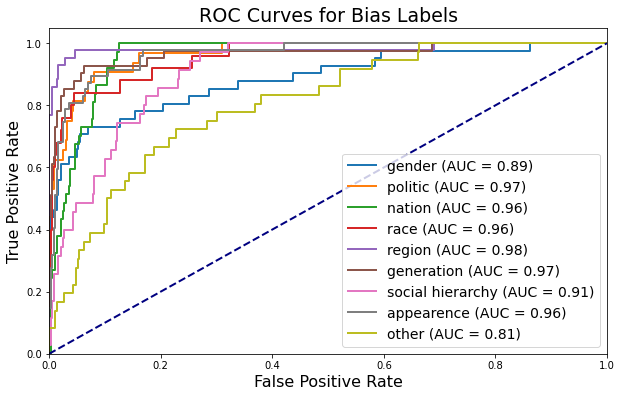

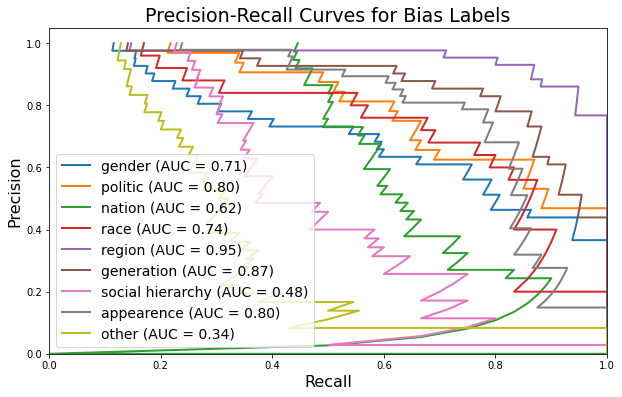


Eval results for gender.
accuracy : 84.41
precision : 36.9
recall : 75.61
f1 : 49.6
matthews_corrcoef : 45.4
pr_auc : 0.7055422850061945
roc_auc : 0.8851038097157832

Eval results for politic.
accuracy : 79.21
precision : 27.19
recall : 96.88
f1 : 42.47
matthews_corrcoef : 44.74
pr_auc : 0.8026786418954406
roc_auc : 0.9664818548387097

Eval results for nation.
accuracy : 88.86
precision : 44.74
recall : 91.89
f1 : 60.18
matthews_corrcoef : 59.38
pr_auc : 0.6213222115345515
roc_auc : 0.958391634140953

Eval results for race.
accuracy : 88.61
precision : 33.33
recall : 84.0
f1 : 47.73
matthews_corrcoef : 48.43
pr_auc : 0.7436845489126824
roc_auc : 0.9566226912928759

Eval results for region.
accuracy : 95.3
precision : 70.69
recall : 95.35
f1 : 81.19
matthews_corrcoef : 79.72
pr_auc : 0.9547973678839319
roc_auc : 0.9806094182825484

Eval results for generation.
accuracy : 91.09
precision : 53.52
recall : 92.68
f1 : 67.86
matthews_corrcoef : 66.32
pr_auc : 0.8740939684598132
roc_auc : 0.

epoch: 2, valid loss: 8.9268: 100%|████████████████████████████████████████| 101/101 [00:16<00:00,  6.22it/s]


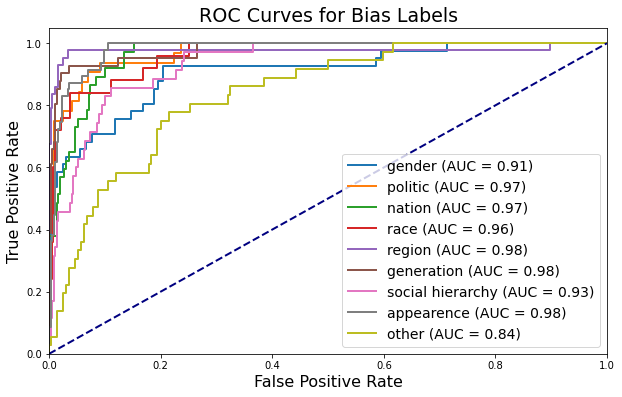

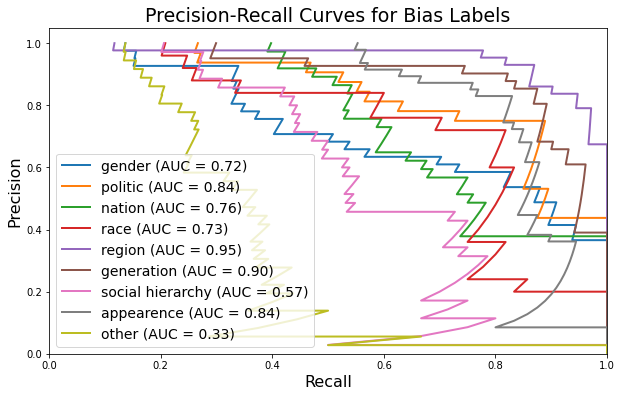


Eval results for gender.
accuracy : 84.9
precision : 37.8
recall : 75.61
f1 : 50.41
matthews_corrcoef : 46.22
pr_auc : 0.7236787875422398
roc_auc : 0.9086877645635961

Eval results for politic.
accuracy : 90.1
precision : 44.12
recall : 93.75
f1 : 60.0
matthews_corrcoef : 60.3
pr_auc : 0.8362952223802351
roc_auc : 0.9727822580645161

Eval results for nation.
accuracy : 89.36
precision : 45.95
recall : 91.89
f1 : 61.26
matthews_corrcoef : 60.4
pr_auc : 0.7574637243998579
roc_auc : 0.965387731055306

Eval results for race.
accuracy : 88.61
precision : 33.85
recall : 88.0
f1 : 48.89
matthews_corrcoef : 50.27
pr_auc : 0.7329744726934451
roc_auc : 0.963377308707124

Eval results for region.
accuracy : 97.28
precision : 82.0
recall : 95.35
f1 : 88.17
matthews_corrcoef : 86.96
pr_auc : 0.9521865025586735
roc_auc : 0.9757778779875023

Eval results for generation.
accuracy : 95.05
precision : 69.09
recall : 92.68
f1 : 79.17
matthews_corrcoef : 77.49
pr_auc : 0.9010631631986986
roc_auc : 0.9791

epoch: 3, valid loss: 8.633: 100%|█████████████████████████████████████████| 101/101 [00:15<00:00,  6.32it/s]


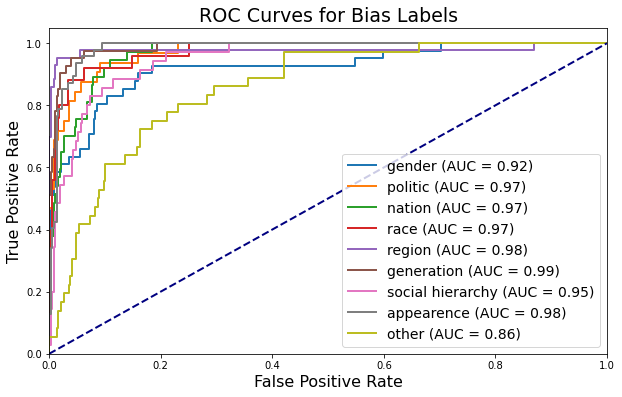

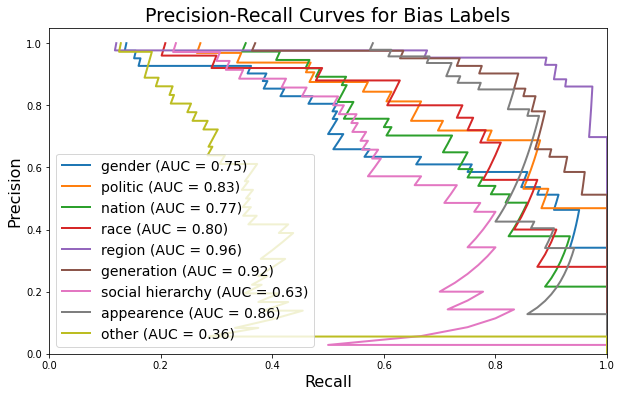


Eval results for gender.
accuracy : 90.59
precision : 52.94
recall : 65.85
f1 : 58.7
matthews_corrcoef : 53.86
pr_auc : 0.7475005200649925
roc_auc : 0.921386817173957

Eval results for politic.
accuracy : 89.6
precision : 42.86
recall : 93.75
f1 : 58.82
matthews_corrcoef : 59.22
pr_auc : 0.8323337167651799
roc_auc : 0.9739583333333334

Eval results for nation.
accuracy : 89.6
precision : 46.58
recall : 91.89
f1 : 61.82
matthews_corrcoef : 60.92
pr_auc : 0.7698178180133282
roc_auc : 0.9675233816923191

Eval results for race.
accuracy : 91.09
precision : 40.35
recall : 92.0
f1 : 56.1
matthews_corrcoef : 57.47
pr_auc : 0.7990385125164272
roc_auc : 0.9744591029023746

Eval results for region.
accuracy : 97.77
precision : 85.42
recall : 95.35
f1 : 90.11
matthews_corrcoef : 89.03
pr_auc : 0.9586110361187644
roc_auc : 0.9770018681955808

Eval results for generation.
accuracy : 95.79
precision : 72.22
recall : 95.12
f1 : 82.11
matthews_corrcoef : 80.74
pr_auc : 0.9217514174082132
roc_auc : 0.

epoch: 4, valid loss: 9.5687: 100%|████████████████████████████████████████| 101/101 [00:16<00:00,  6.21it/s]


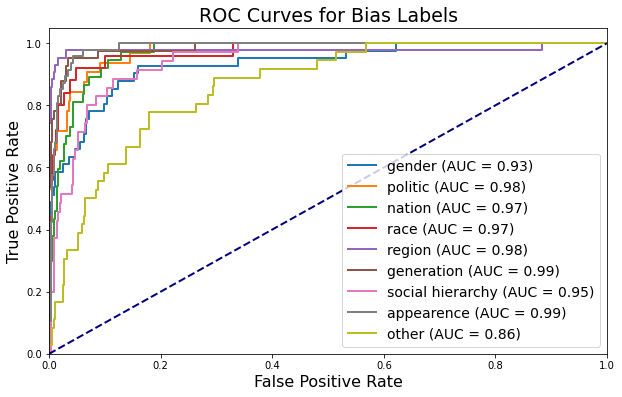

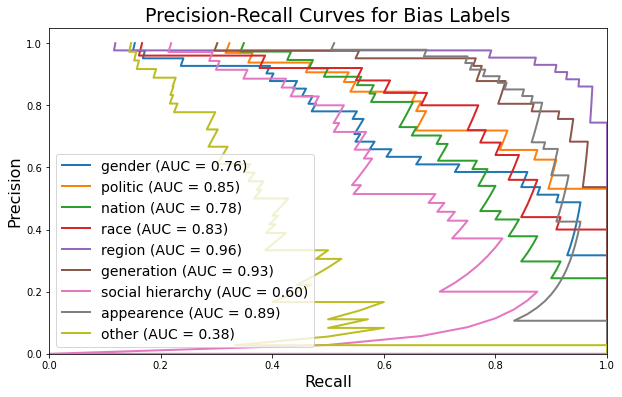


Eval results for gender.
accuracy : 91.09
precision : 54.24
recall : 78.05
f1 : 64.0
matthews_corrcoef : 60.38
pr_auc : 0.757870597818211
roc_auc : 0.9334139622387959

Eval results for politic.
accuracy : 91.09
precision : 46.88
recall : 93.75
f1 : 62.5
matthews_corrcoef : 62.58
pr_auc : 0.8462617301127928
roc_auc : 0.9770665322580645

Eval results for nation.
accuracy : 90.1
precision : 47.89
recall : 91.89
f1 : 62.96
matthews_corrcoef : 62.0
pr_auc : 0.7754786787262737
roc_auc : 0.9701745342072318

Eval results for race.
accuracy : 92.08
precision : 43.4
recall : 92.0
f1 : 58.97
matthews_corrcoef : 60.01
pr_auc : 0.825779630946356
roc_auc : 0.9747757255936675

Eval results for region.
accuracy : 98.02
precision : 87.23
recall : 95.35
f1 : 91.11
matthews_corrcoef : 90.11
pr_auc : 0.963324878083523
roc_auc : 0.9774528119564516

Eval results for generation.
accuracy : 95.3
precision : 69.64
recall : 95.12
f1 : 80.41
matthews_corrcoef : 79.03
pr_auc : 0.9255461482253275
roc_auc : 0.9862

epoch: 5, valid loss: 10.0119: 100%|███████████████████████████████████████| 101/101 [00:15<00:00,  6.43it/s]


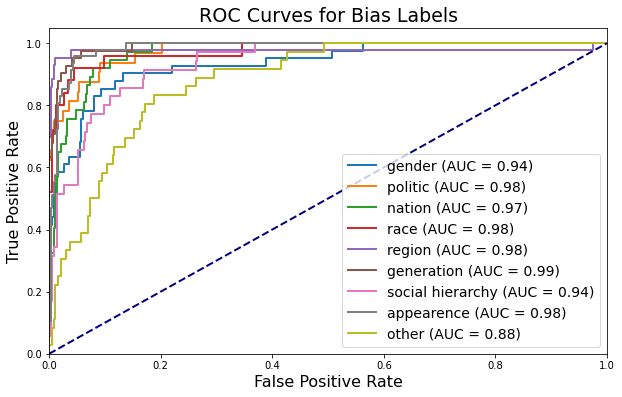

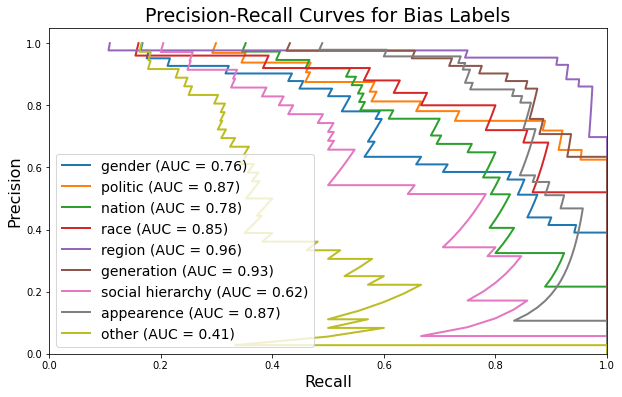


Eval results for gender.
accuracy : 91.83
precision : 57.14
recall : 78.05
f1 : 65.98
matthews_corrcoef : 62.43
pr_auc : 0.7596601426839144
roc_auc : 0.9351609218571524

Eval results for politic.
accuracy : 92.33
precision : 50.91
recall : 87.5
f1 : 64.37
matthews_corrcoef : 63.19
pr_auc : 0.868764309560673
roc_auc : 0.977486559139785

Eval results for nation.
accuracy : 90.84
precision : 50.0
recall : 91.89
f1 : 64.76
matthews_corrcoef : 63.7
pr_auc : 0.7762368126885744
roc_auc : 0.9701745342072318

Eval results for race.
accuracy : 94.06
precision : 51.11
recall : 92.0
f1 : 65.71
matthews_corrcoef : 66.01
pr_auc : 0.8549650040850381
roc_auc : 0.9758311345646438

Eval results for region.
accuracy : 98.27
precision : 90.91
recall : 93.02
f1 : 91.95
matthews_corrcoef : 90.99
pr_auc : 0.9620556166448226
roc_auc : 0.9751980931520969

Eval results for generation.
accuracy : 95.54
precision : 71.7
recall : 92.68
f1 : 80.85
matthews_corrcoef : 79.2
pr_auc : 0.9337545434304504
roc_auc : 0.98

epoch: 6, valid loss: 11.7087: 100%|███████████████████████████████████████| 101/101 [00:15<00:00,  6.45it/s]


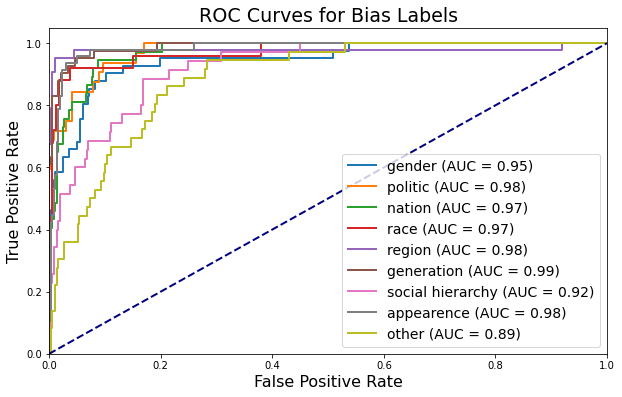

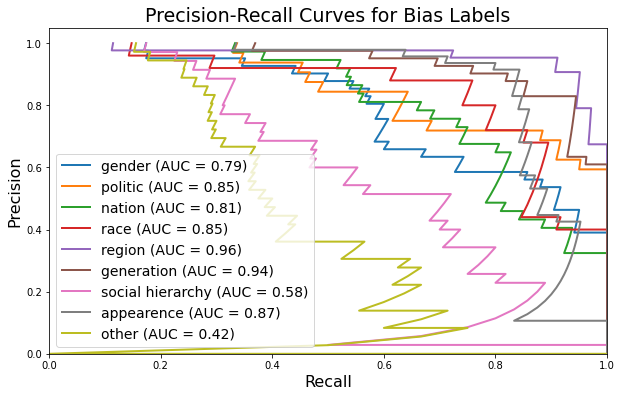


Eval results for gender.
accuracy : 91.83
precision : 56.67
recall : 82.93
f1 : 67.33
matthews_corrcoef : 64.34
pr_auc : 0.78881290807132
roc_auc : 0.9471208761674393

Eval results for politic.
accuracy : 90.84
precision : 45.9
recall : 87.5
f1 : 60.22
matthews_corrcoef : 59.31
pr_auc : 0.8533475277858482
roc_auc : 0.9762264784946236

Eval results for nation.
accuracy : 91.83
precision : 53.23
recall : 89.19
f1 : 66.67
matthews_corrcoef : 65.05
pr_auc : 0.8100828760974896
roc_auc : 0.9725311142204875

Eval results for race.
accuracy : 91.83
precision : 42.59
recall : 92.0
f1 : 58.23
matthews_corrcoef : 59.35
pr_auc : 0.8457302490851951
roc_auc : 0.9730870712401055

Eval results for region.
accuracy : 98.51
precision : 91.11
recall : 95.35
f1 : 93.18
matthews_corrcoef : 92.38
pr_auc : 0.9590470940599138
roc_auc : 0.9760999806738387

Eval results for generation.
accuracy : 95.79
precision : 73.08
recall : 92.68
f1 : 81.72
matthews_corrcoef : 80.1
pr_auc : 0.9361295700107918
roc_auc : 0.

epoch: 7, valid loss: 13.9314: 100%|███████████████████████████████████████| 101/101 [00:14<00:00,  7.01it/s]


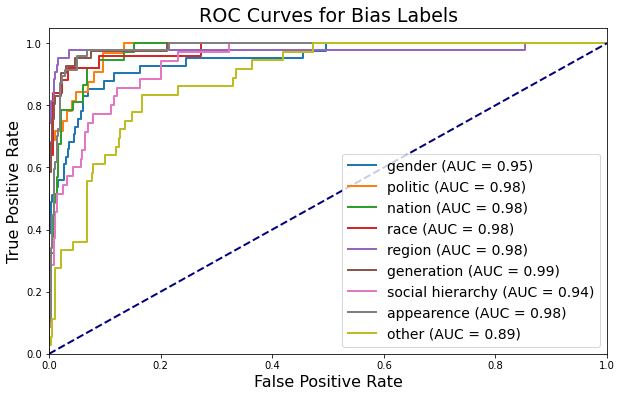

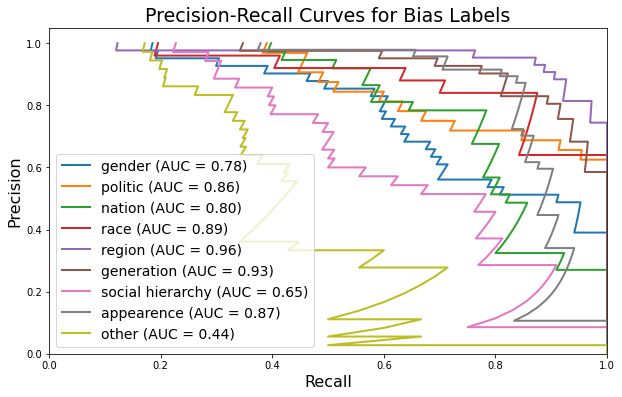


Eval results for gender.
accuracy : 92.82
precision : 60.71
recall : 82.93
f1 : 70.1
matthews_corrcoef : 67.17
pr_auc : 0.78236420354512
roc_auc : 0.9471880669219915

Eval results for politic.
accuracy : 92.08
precision : 50.0
recall : 87.5
f1 : 63.64
matthews_corrcoef : 62.5
pr_auc : 0.8635342273637348
roc_auc : 0.9799227150537635

Eval results for nation.
accuracy : 92.57
precision : 56.14
recall : 86.49
f1 : 68.09
matthews_corrcoef : 66.02
pr_auc : 0.804909813329117
roc_auc : 0.975108623609986

Eval results for race.
accuracy : 94.55
precision : 53.49
recall : 92.0
f1 : 67.65
matthews_corrcoef : 67.75
pr_auc : 0.8895304525928991
roc_auc : 0.9816358839050132

Eval results for region.
accuracy : 97.77
precision : 92.5
recall : 86.05
f1 : 89.16
matthews_corrcoef : 87.99
pr_auc : 0.9588870710920523
roc_auc : 0.9775816530309862

Eval results for generation.
accuracy : 95.54
precision : 71.7
recall : 92.68
f1 : 80.85
matthews_corrcoef : 79.2
pr_auc : 0.9325899743734348
roc_auc : 0.988174

epoch: 8, valid loss: 15.5587: 100%|███████████████████████████████████████| 101/101 [00:09<00:00, 10.12it/s]


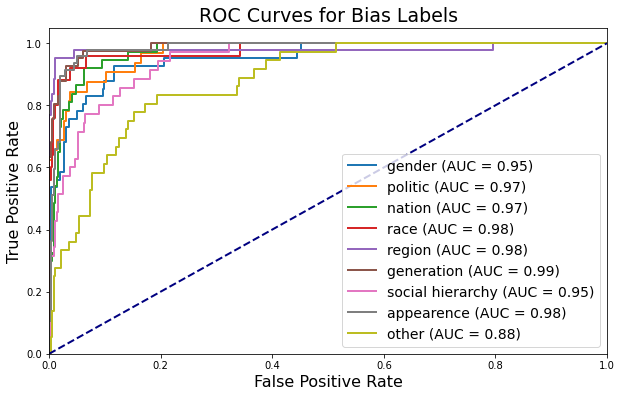

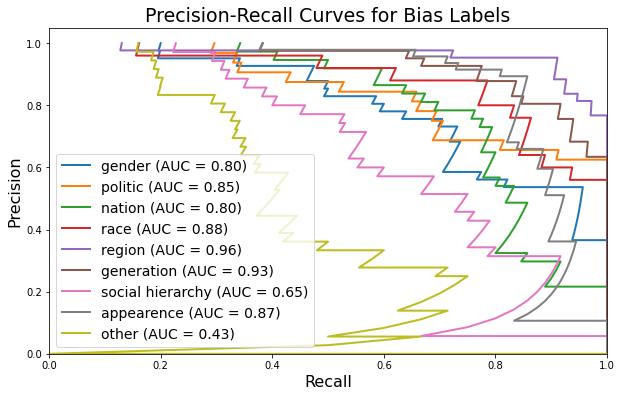


Eval results for gender.
accuracy : 92.57
precision : 60.0
recall : 80.49
f1 : 68.75
matthews_corrcoef : 65.54
pr_auc : 0.7986080852628454
roc_auc : 0.9520929920043002

Eval results for politic.
accuracy : 93.81
precision : 57.45
recall : 84.38
f1 : 68.35
matthews_corrcoef : 66.54
pr_auc : 0.8450704771771946
roc_auc : 0.9729502688172043

Eval results for nation.
accuracy : 93.07
precision : 57.63
recall : 91.89
f1 : 70.83
matthews_corrcoef : 69.49
pr_auc : 0.802311434230929
roc_auc : 0.9748140511083291

Eval results for race.
accuracy : 94.55
precision : 53.49
recall : 92.0
f1 : 67.65
matthews_corrcoef : 67.75
pr_auc : 0.881017064020518
roc_auc : 0.9792084432717678

Eval results for region.
accuracy : 98.02
precision : 92.68
recall : 88.37
f1 : 90.48
matthews_corrcoef : 89.4
pr_auc : 0.9607941309603285
roc_auc : 0.9790633253881337

Eval results for generation.
accuracy : 96.04
precision : 74.51
recall : 92.68
f1 : 82.61
matthews_corrcoef : 81.01
pr_auc : 0.9345037066723172
roc_auc : 0

epoch: 9, valid loss: 16.21: 100%|█████████████████████████████████████████| 101/101 [00:10<00:00,  9.91it/s]


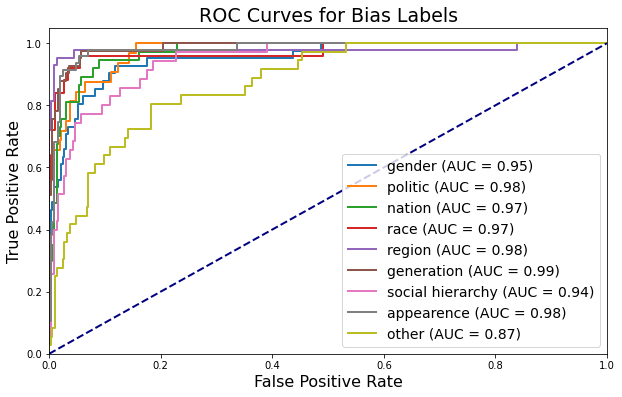

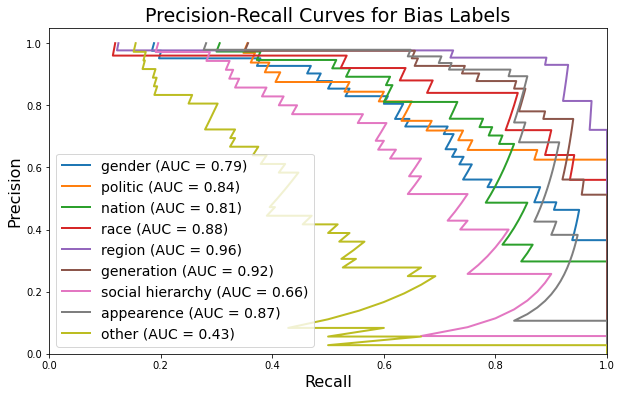


Eval results for gender.
accuracy : 91.34
precision : 54.84
recall : 82.93
f1 : 66.02
matthews_corrcoef : 63.01
pr_auc : 0.7947066859575004
roc_auc : 0.9522273735134046

Eval results for politic.
accuracy : 93.56
precision : 56.25
recall : 84.38
f1 : 67.5
matthews_corrcoef : 65.71
pr_auc : 0.842951595479387
roc_auc : 0.9750504032258065

Eval results for nation.
accuracy : 92.82
precision : 56.9
recall : 89.19
f1 : 69.47
matthews_corrcoef : 67.76
pr_auc : 0.8092425996454491
roc_auc : 0.9732675454746299

Eval results for race.
accuracy : 94.55
precision : 53.33
recall : 96.0
f1 : 68.57
matthews_corrcoef : 69.28
pr_auc : 0.8845220835976115
roc_auc : 0.9738258575197889

Eval results for region.
accuracy : 97.77
precision : 92.5
recall : 86.05
f1 : 89.16
matthews_corrcoef : 87.99
pr_auc : 0.9592126302919509
roc_auc : 0.9779037557173226

Eval results for generation.
accuracy : 95.79
precision : 73.08
recall : 92.68
f1 : 81.72
matthews_corrcoef : 80.1
pr_auc : 0.9219463445908378
roc_auc : 0.

epoch: 10, valid loss: 17.3422: 100%|██████████████████████████████████████| 101/101 [00:07<00:00, 14.02it/s]


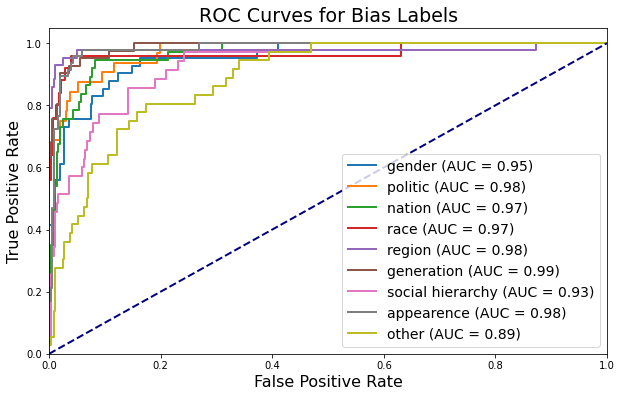

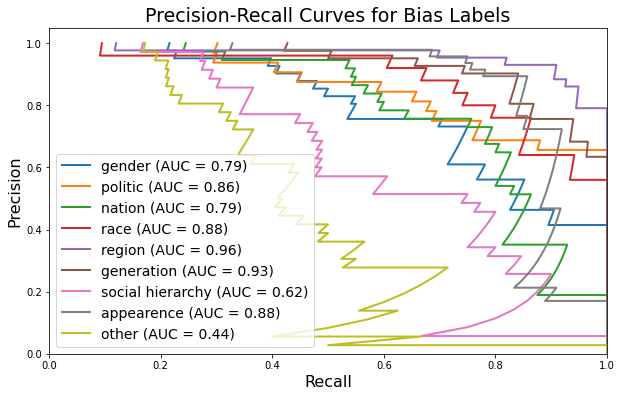


Eval results for gender.
accuracy : 92.33
precision : 59.62
recall : 75.61
f1 : 66.67
matthews_corrcoef : 62.96
pr_auc : 0.7894325162798079
roc_auc : 0.9533024255862393

Eval results for politic.
accuracy : 94.06
precision : 58.7
recall : 84.38
f1 : 69.23
matthews_corrcoef : 67.39
pr_auc : 0.8586867160367158
roc_auc : 0.9750504032258065

Eval results for nation.
accuracy : 93.32
precision : 59.62
recall : 83.78
f1 : 69.66
matthews_corrcoef : 67.24
pr_auc : 0.791360795798382
roc_auc : 0.9679652404448045

Eval results for race.
accuracy : 95.54
precision : 58.54
recall : 96.0
f1 : 72.73
matthews_corrcoef : 73.02
pr_auc : 0.8831830513501353
roc_auc : 0.9687598944591029

Eval results for region.
accuracy : 97.77
precision : 94.74
recall : 83.72
f1 : 88.89
matthews_corrcoef : 87.86
pr_auc : 0.9584700845720207
roc_auc : 0.9768730271210461

Eval results for generation.
accuracy : 96.04
precision : 74.51
recall : 92.68
f1 : 82.61
matthews_corrcoef : 81.01
pr_auc : 0.9299547801175527
roc_auc :

epoch: 11, valid loss: 21.2293: 100%|██████████████████████████████████████| 101/101 [00:07<00:00, 14.35it/s]


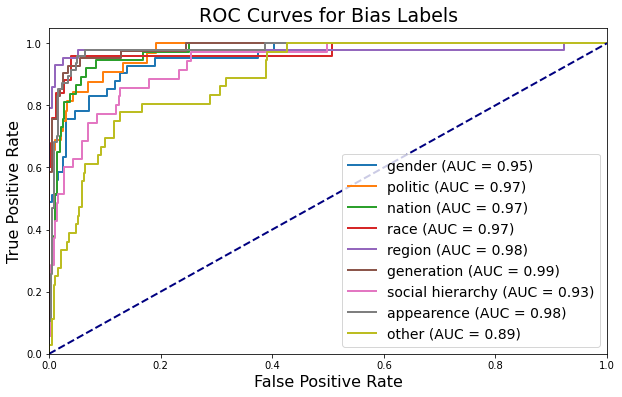

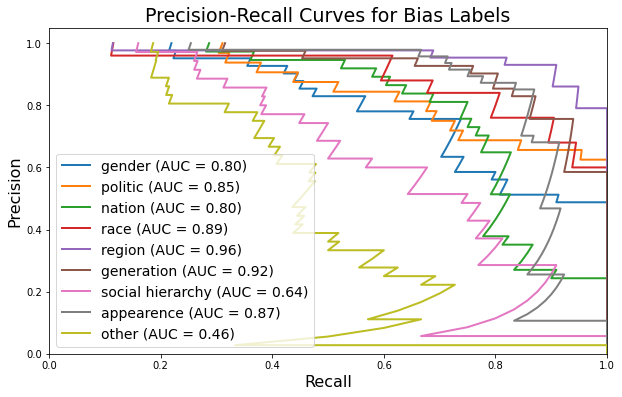


Eval results for gender.
accuracy : 92.33
precision : 59.26
recall : 78.05
f1 : 67.37
matthews_corrcoef : 63.88
pr_auc : 0.7994000192630013
roc_auc : 0.9537055701135524

Eval results for politic.
accuracy : 94.55
precision : 61.9
recall : 81.25
f1 : 70.27
matthews_corrcoef : 68.09
pr_auc : 0.8502785418797268
roc_auc : 0.9741263440860215

Eval results for nation.
accuracy : 93.81
precision : 61.54
recall : 86.49
f1 : 71.91
matthews_corrcoef : 69.8
pr_auc : 0.8001563367436922
roc_auc : 0.9728993298475588

Eval results for race.
accuracy : 95.3
precision : 57.14
recall : 96.0
f1 : 71.64
matthews_corrcoef : 72.04
pr_auc : 0.8914979694367493
roc_auc : 0.9738258575197889

Eval results for region.
accuracy : 98.02
precision : 94.87
recall : 86.05
f1 : 90.24
matthews_corrcoef : 89.28
pr_auc : 0.9575505176136487
roc_auc : 0.9755846163757005

Eval results for generation.
accuracy : 96.29
precision : 76.0
recall : 92.68
f1 : 83.52
matthews_corrcoef : 81.96
pr_auc : 0.9204641803244341
roc_auc : 0

epoch: 12, valid loss: 22.2421: 100%|██████████████████████████████████████| 101/101 [00:06<00:00, 14.57it/s]


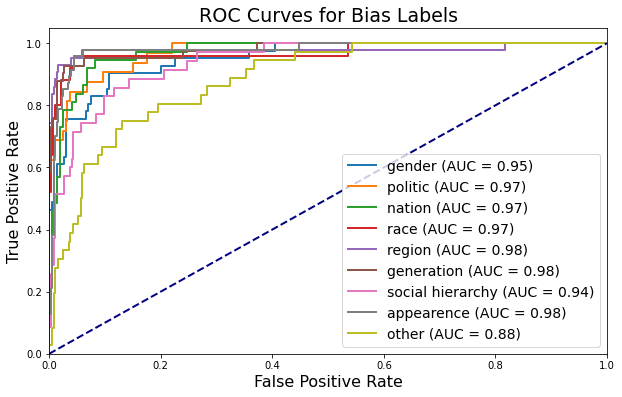

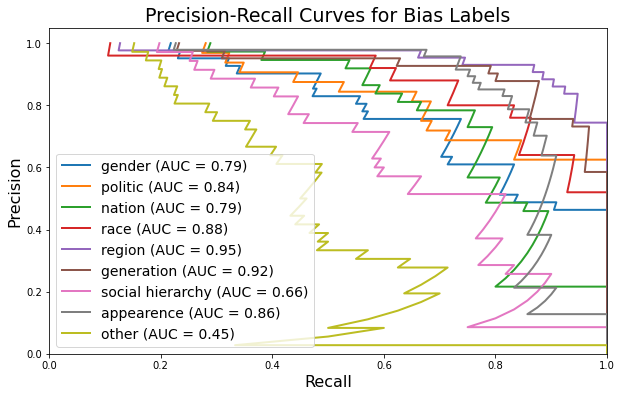


Eval results for gender.
accuracy : 92.82
precision : 62.0
recall : 75.61
f1 : 68.13
matthews_corrcoef : 64.53
pr_auc : 0.79467781478056
roc_auc : 0.9519586104951958

Eval results for politic.
accuracy : 95.05
precision : 65.0
recall : 81.25
f1 : 72.22
matthews_corrcoef : 70.06
pr_auc : 0.8433720150387746
roc_auc : 0.9722782258064515

Eval results for nation.
accuracy : 94.06
precision : 63.83
recall : 81.08
f1 : 71.43
matthews_corrcoef : 68.77
pr_auc : 0.7927736210991706
roc_auc : 0.9720892554680021

Eval results for race.
accuracy : 96.04
precision : 62.16
recall : 92.0
f1 : 74.19
matthews_corrcoef : 73.76
pr_auc : 0.8779046337578873
roc_auc : 0.9719261213720316

Eval results for region.
accuracy : 97.52
precision : 92.31
recall : 83.72
f1 : 87.8
matthews_corrcoef : 86.56
pr_auc : 0.9509608668778107
roc_auc : 0.977066288732848

Eval results for generation.
accuracy : 96.78
precision : 79.17
recall : 92.68
f1 : 85.39
matthews_corrcoef : 83.93
pr_auc : 0.9227700178687819
roc_auc : 0.9

epoch: 13, valid loss: 25.237: 100%|███████████████████████████████████████| 101/101 [00:06<00:00, 14.61it/s]


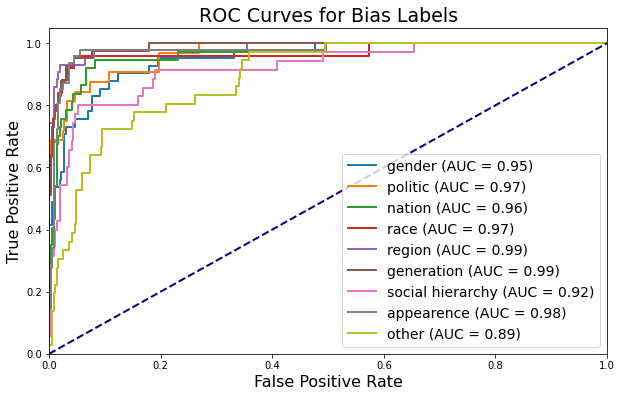

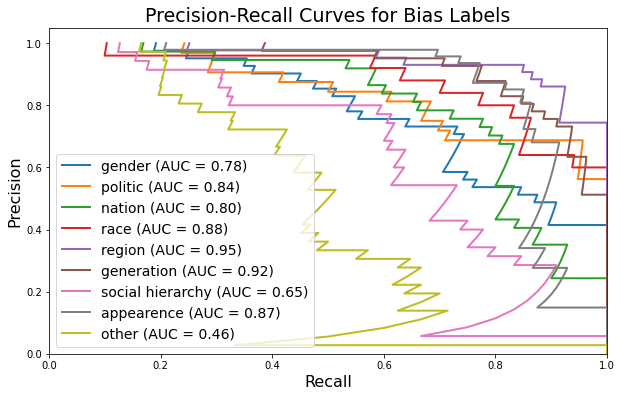


Eval results for gender.
accuracy : 91.83
precision : 57.41
recall : 75.61
f1 : 65.26
matthews_corrcoef : 61.47
pr_auc : 0.7843505290440373
roc_auc : 0.9507491769132567

Eval results for politic.
accuracy : 95.3
precision : 66.67
recall : 81.25
f1 : 73.24
matthews_corrcoef : 71.1
pr_auc : 0.8414791307549727
roc_auc : 0.9683299731182795

Eval results for nation.
accuracy : 95.05
precision : 70.73
recall : 78.38
f1 : 74.36
matthews_corrcoef : 71.74
pr_auc : 0.8048249625375442
roc_auc : 0.9645776566757494

Eval results for race.
accuracy : 95.79
precision : 60.53
recall : 92.0
f1 : 73.02
matthews_corrcoef : 72.67
pr_auc : 0.8849105417274031
roc_auc : 0.9708707124010554

Eval results for region.
accuracy : 97.77
precision : 92.5
recall : 86.05
f1 : 89.16
matthews_corrcoef : 87.99
pr_auc : 0.9458594451307377
roc_auc : 0.9862784255620691

Eval results for generation.
accuracy : 96.29
precision : 76.0
recall : 92.68
f1 : 83.52
matthews_corrcoef : 81.96
pr_auc : 0.9240314641020817
roc_auc : 0

epoch: 14, valid loss: 22.954: 100%|███████████████████████████████████████| 101/101 [00:06<00:00, 14.73it/s]


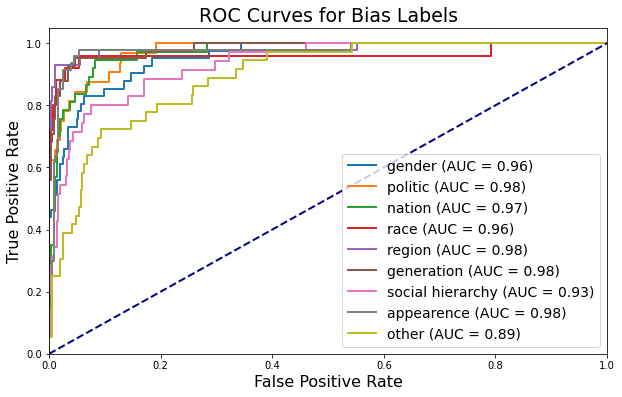

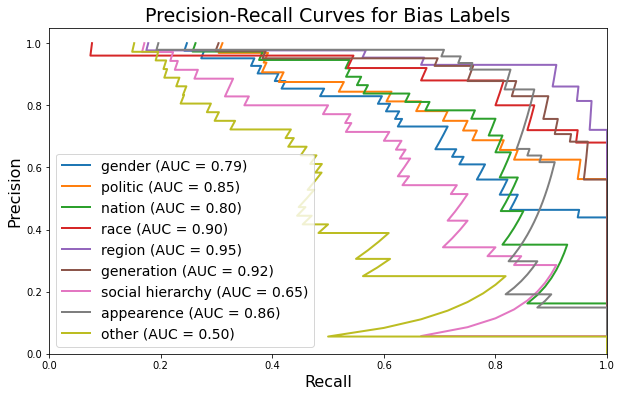


Eval results for gender.
accuracy : 92.57
precision : 60.38
recall : 78.05
f1 : 68.09
matthews_corrcoef : 64.64
pr_auc : 0.7902467106616025
roc_auc : 0.9553181482228045

Eval results for politic.
accuracy : 94.55
precision : 61.9
recall : 81.25
f1 : 70.27
matthews_corrcoef : 68.09
pr_auc : 0.845597310137045
roc_auc : 0.9750504032258064

Eval results for nation.
accuracy : 93.56
precision : 60.78
recall : 83.78
f1 : 70.45
matthews_corrcoef : 68.03
pr_auc : 0.7974666298030615
roc_auc : 0.9715001104646882

Eval results for race.
accuracy : 96.53
precision : 66.67
recall : 88.0
f1 : 75.86
matthews_corrcoef : 74.86
pr_auc : 0.9030093153957457
roc_auc : 0.9632717678100263

Eval results for region.
accuracy : 98.02
precision : 94.87
recall : 86.05
f1 : 90.24
matthews_corrcoef : 89.28
pr_auc : 0.9512648461620211
roc_auc : 0.9825420344005669

Eval results for generation.
accuracy : 96.04
precision : 75.51
recall : 90.24
f1 : 82.22
matthews_corrcoef : 80.42
pr_auc : 0.9217323280220564
roc_auc :

epoch: 15, valid loss: 24.9534: 100%|██████████████████████████████████████| 101/101 [00:07<00:00, 14.27it/s]


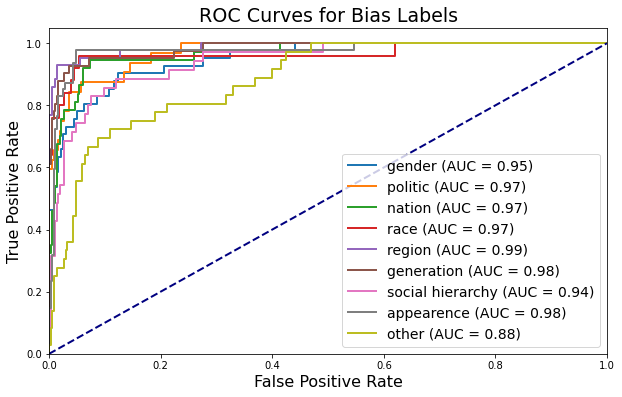

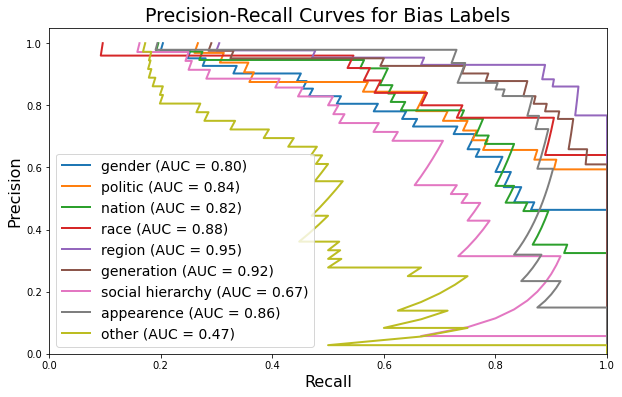


Eval results for gender.
accuracy : 92.33
precision : 58.93
recall : 80.49
f1 : 68.04
matthews_corrcoef : 64.8
pr_auc : 0.7962887237654406
roc_auc : 0.950480413895048

Eval results for politic.
accuracy : 95.05
precision : 65.79
recall : 78.12
f1 : 71.43
matthews_corrcoef : 69.04
pr_auc : 0.8427888388795584
roc_auc : 0.9711861559139785

Eval results for nation.
accuracy : 95.05
precision : 70.73
recall : 78.38
f1 : 74.36
matthews_corrcoef : 71.74
pr_auc : 0.816280762668529
roc_auc : 0.9667133073127624

Eval results for race.
accuracy : 95.3
precision : 57.89
recall : 88.0
f1 : 69.84
matthews_corrcoef : 69.15
pr_auc : 0.8756981433621974
roc_auc : 0.9672823218997362

Eval results for region.
accuracy : 98.02
precision : 94.87
recall : 86.05
f1 : 90.24
matthews_corrcoef : 89.28
pr_auc : 0.951301513764716
roc_auc : 0.9880177800682857

Eval results for generation.
accuracy : 96.53
precision : 78.72
recall : 90.24
f1 : 84.09
matthews_corrcoef : 82.4
pr_auc : 0.9216717525069477
roc_auc : 0.9

epoch: 16, valid loss: 25.2293: 100%|██████████████████████████████████████| 101/101 [00:06<00:00, 14.57it/s]


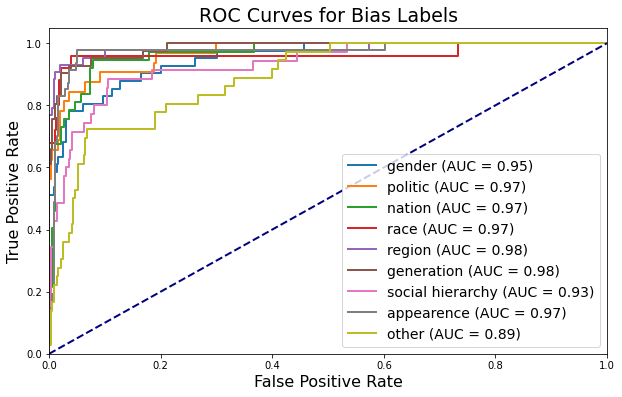

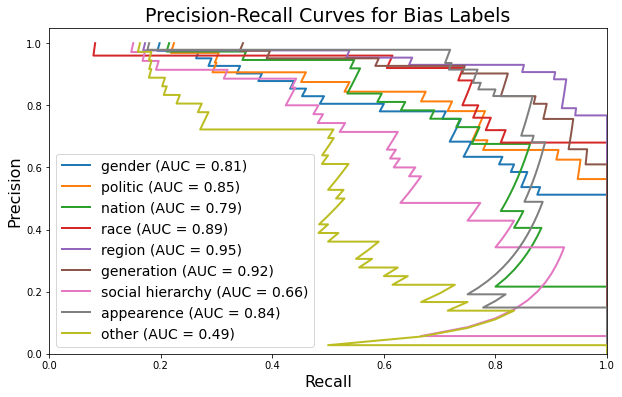


Eval results for gender.
accuracy : 92.57
precision : 60.0
recall : 80.49
f1 : 68.75
matthews_corrcoef : 65.54
pr_auc : 0.8063212728391967
roc_auc : 0.9507491769132568

Eval results for politic.
accuracy : 95.79
precision : 71.43
recall : 78.12
f1 : 74.63
matthews_corrcoef : 72.42
pr_auc : 0.8468892478341189
roc_auc : 0.9694220430107526

Eval results for nation.
accuracy : 94.8
precision : 69.05
recall : 78.38
f1 : 73.42
matthews_corrcoef : 70.72
pr_auc : 0.7905370570790995
roc_auc : 0.9675970248177332

Eval results for race.
accuracy : 96.53
precision : 65.71
recall : 92.0
f1 : 76.67
matthews_corrcoef : 76.09
pr_auc : 0.8917693645927077
roc_auc : 0.9651715039577836

Eval results for region.
accuracy : 97.77
precision : 92.5
recall : 86.05
f1 : 89.16
matthews_corrcoef : 87.99
pr_auc : 0.9475522809343854
roc_auc : 0.9813180441924886

Eval results for generation.
accuracy : 96.29
precision : 77.08
recall : 90.24
f1 : 83.15
matthews_corrcoef : 81.39
pr_auc : 0.9227125554252271
roc_auc : 

epoch: 17, valid loss: 26.0782: 100%|██████████████████████████████████████| 101/101 [00:07<00:00, 13.70it/s]


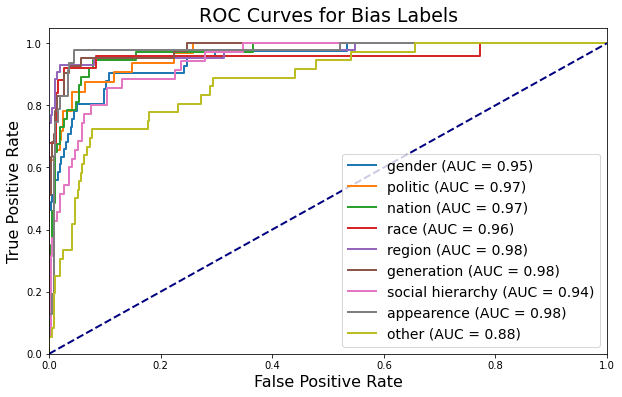

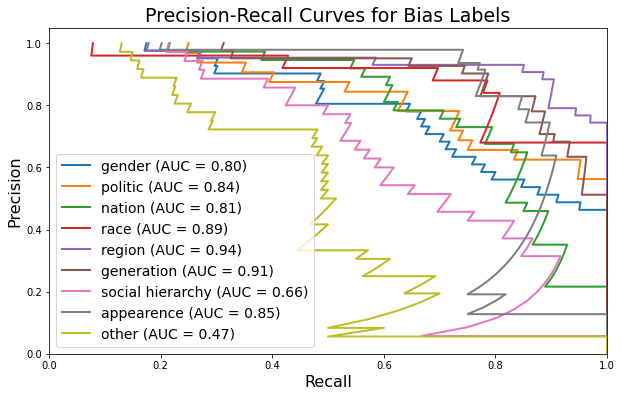


Eval results for gender.
accuracy : 93.56
precision : 64.71
recall : 80.49
f1 : 71.74
matthews_corrcoef : 68.67
pr_auc : 0.797716265958699
roc_auc : 0.949270980313109

Eval results for politic.
accuracy : 95.05
precision : 65.79
recall : 78.12
f1 : 71.43
matthews_corrcoef : 69.04
pr_auc : 0.8358815499977181
roc_auc : 0.9689180107526881

Eval results for nation.
accuracy : 94.8
precision : 70.0
recall : 75.68
f1 : 72.73
matthews_corrcoef : 69.92
pr_auc : 0.8098440986199434
roc_auc : 0.9701008910818175

Eval results for race.
accuracy : 96.78
precision : 68.75
recall : 88.0
f1 : 77.19
matthews_corrcoef : 76.16
pr_auc : 0.8855602288730667
roc_auc : 0.9618997361477573

Eval results for region.
accuracy : 97.03
precision : 96.97
recall : 74.42
f1 : 84.21
matthews_corrcoef : 83.48
pr_auc : 0.9366495237381127
roc_auc : 0.9760999806738387

Eval results for generation.
accuracy : 96.04
precision : 79.07
recall : 82.93
f1 : 80.95
matthews_corrcoef : 78.77
pr_auc : 0.9102098304885311
roc_auc : 0

epoch: 18, valid loss: 27.8783: 100%|██████████████████████████████████████| 101/101 [00:07<00:00, 14.08it/s]


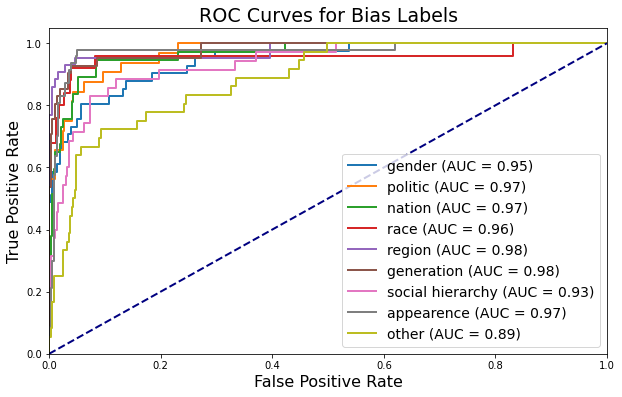

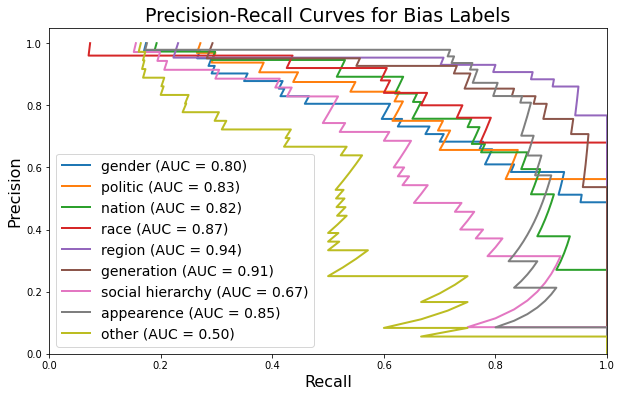


Eval results for gender.
accuracy : 92.33
precision : 59.62
recall : 75.61
f1 : 66.67
matthews_corrcoef : 62.96
pr_auc : 0.7994414843997479
roc_auc : 0.9454411073036351

Eval results for politic.
accuracy : 95.54
precision : 70.59
recall : 75.0
f1 : 72.73
matthews_corrcoef : 70.34
pr_auc : 0.8253728096722277
roc_auc : 0.9704301075268817

Eval results for nation.
accuracy : 95.3
precision : 75.0
recall : 72.97
f1 : 73.97
matthews_corrcoef : 71.4
pr_auc : 0.8185255857771877
roc_auc : 0.9669342366890051

Eval results for race.
accuracy : 96.29
precision : 66.67
recall : 80.0
f1 : 72.73
matthews_corrcoef : 71.09
pr_auc : 0.8672558324309068
roc_auc : 0.9575725593667546

Eval results for region.
accuracy : 97.03
precision : 94.29
recall : 76.74
f1 : 84.62
matthews_corrcoef : 83.53
pr_auc : 0.942060801344905
roc_auc : 0.97867680216453

Eval results for generation.
accuracy : 96.78
precision : 83.33
recall : 85.37
f1 : 84.34
matthews_corrcoef : 82.55
pr_auc : 0.9133104679194084
roc_auc : 0.97

epoch: 19, valid loss: 27.2559: 100%|██████████████████████████████████████| 101/101 [00:10<00:00,  9.21it/s]


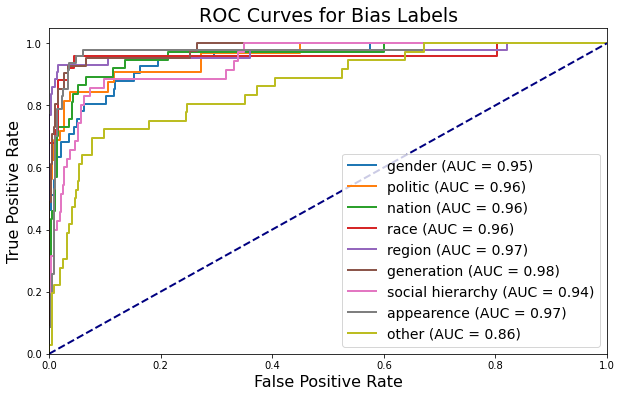

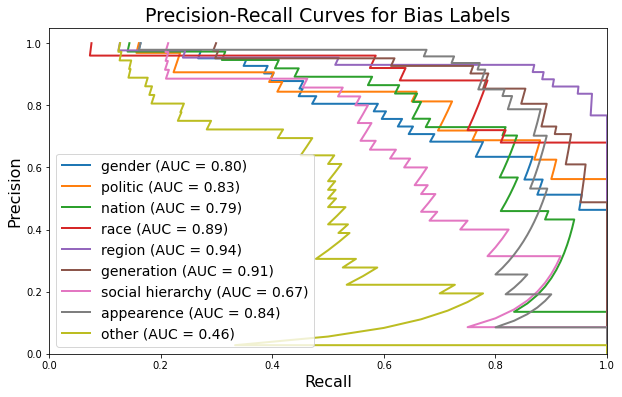


Eval results for gender.
accuracy : 92.08
precision : 58.18
recall : 78.05
f1 : 66.67
matthews_corrcoef : 63.15
pr_auc : 0.8020552789751569
roc_auc : 0.9496069340858698

Eval results for politic.
accuracy : 96.04
precision : 76.67
recall : 71.88
f1 : 74.19
matthews_corrcoef : 72.1
pr_auc : 0.8292029314831176
roc_auc : 0.9569892473118279

Eval results for nation.
accuracy : 94.55
precision : 69.23
recall : 72.97
f1 : 71.05
matthews_corrcoef : 68.08
pr_auc : 0.7904100206314991
roc_auc : 0.9593489947713382

Eval results for race.
accuracy : 97.03
precision : 70.97
recall : 88.0
f1 : 78.57
matthews_corrcoef : 77.51
pr_auc : 0.8870884350441696
roc_auc : 0.9617941952506597

Eval results for region.
accuracy : 97.28
precision : 97.06
recall : 76.74
f1 : 85.71
matthews_corrcoef : 84.94
pr_auc : 0.9396201225693945
roc_auc : 0.9688204599626361

Eval results for generation.
accuracy : 96.29
precision : 78.26
recall : 87.8
f1 : 82.76
matthews_corrcoef : 80.85
pr_auc : 0.9101222350282292
roc_auc :

epoch: 20, valid loss: 29.652: 100%|███████████████████████████████████████| 101/101 [00:07<00:00, 13.76it/s]


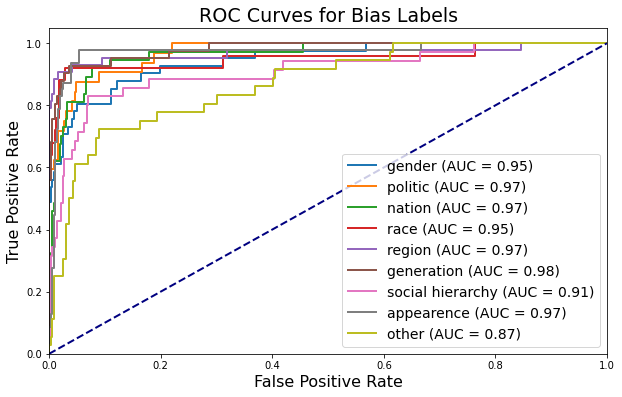

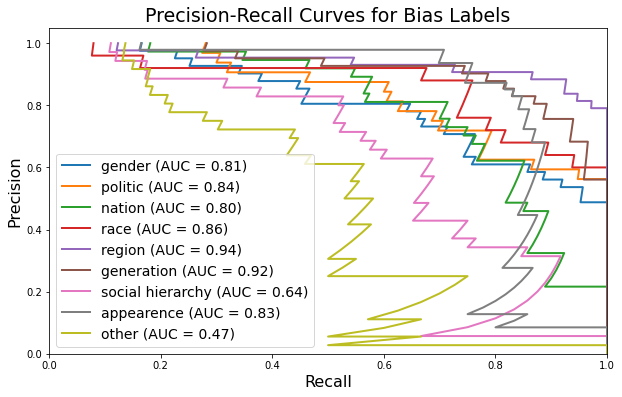


Eval results for gender.
accuracy : 92.82
precision : 61.11
recall : 80.49
f1 : 69.47
matthews_corrcoef : 66.29
pr_auc : 0.8052297736547608
roc_auc : 0.9451723442854264

Eval results for politic.
accuracy : 95.54
precision : 71.88
recall : 71.88
f1 : 71.88
matthews_corrcoef : 69.46
pr_auc : 0.836289437210558
roc_auc : 0.9714381720430108

Eval results for nation.
accuracy : 94.8
precision : 71.05
recall : 72.97
f1 : 72.0
matthews_corrcoef : 69.14
pr_auc : 0.79699429311768
roc_auc : 0.9650195154282347

Eval results for race.
accuracy : 97.03
precision : 76.0
recall : 76.0
f1 : 76.0
matthews_corrcoef : 74.42
pr_auc : 0.8633344330197296
roc_auc : 0.952401055408971

Eval results for region.
accuracy : 97.77
precision : 100.0
recall : 79.07
f1 : 88.31
matthews_corrcoef : 87.83
pr_auc : 0.9369629495090617
roc_auc : 0.9688204599626361

Eval results for generation.
accuracy : 96.53
precision : 81.4
recall : 85.37
f1 : 83.33
matthews_corrcoef : 81.43
pr_auc : 0.9158426903982313
roc_auc : 0.9809

In [19]:
def do_eval(epoch):
    # No gradient computation during evaluation
    with torch.no_grad():
        # Run one epoch without training (inference only)
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]
        
        # Group results by category
        all_results = [ [result_dict[f'results_{i}'] for result_dict in results] for i in range(1, 10) ]
        all_results = [ [item for sublist in result_list for item in sublist] for result_list in all_results ]
        
        # Extract probabilities from results
        probs = [ [result['prob'] for result in results] for results in all_results ]
        all_probs = []
        for p in probs:
            tensors = []
            for t in p:
                if isinstance(t, torch.Tensor):
                    tensors.append(t.view(1, -1))
                else:
                    tensors.append(torch.tensor([[t]]))
            all_probs.append(torch.cat(tensors))
        
        # Evaluate the model using the evaluation data
        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            all_results=all_results,
            all_probs=all_probs,
        )
        
        category_labels = {
            1: "gender",
            2: "politic",
            3: "nation",
            4: "race",
            5: "region",
            6: "generation",
            7: "social Class",
            8: "appearance",
            9: "oher",
        }
        
        # Print evaluation results by category
        for i in range(1, 10):
            label_name = category_labels.get(i, f"Category {i}")
            print(f"\nEval results for {label_name}.")
            for k, v in eval_results[f"results_{i}"].items():
                print(f"{k} : {v}")
            
    return [eval_results[f"results_{i}"] for i in range(1, 10)] +  [eval_results[f"pr_auc_{i}"] for i in range(1, 10)]

                                                                    
train_losses = []
val_f1 = []
val_roc_auc= []
val_accuracy = []
val_pr_auc = []
best_avg_score = 0
                                                                    
if config.do_train:
    # Start training over a number of epochs
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)
        
        # Optionally evaluate model during training
        if config.do_eval_during_train:
            eval_results = do_eval(epoch)
            
            # Store evaluation metrics
            val_f1.append(tuple(eval_results[i]["f1"] for i in range(9)))
            val_roc_auc.append(tuple(eval_results[i]["roc_auc"] for i in range(9)))
            val_accuracy.append(tuple(eval_results[i]["accuracy"] for i in range(9)))
            val_pr_auc.append(tuple(eval_results[-9:]))
                          
            # Check and store best model based on F1 score
            current_score = [eval_results[i]["f1"] for i in range(9)]
            current_avg_score = sum(current_score) / len(current_score)  # 평균 f1 score 기준으로 best model 정의
            if current_avg_score >= best_avg_score:
                best_avg_score = current_avg_score
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-best-ckpt")
                copy.deepcopy(
                    model_dp.module if hasattr(model_dp, "module") else model_dp._models[0] if hasattr(model_dp, "_models") else model_dp
                ).cpu().save_pretrained(output_dir)
                # Save configuration of best model
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")             

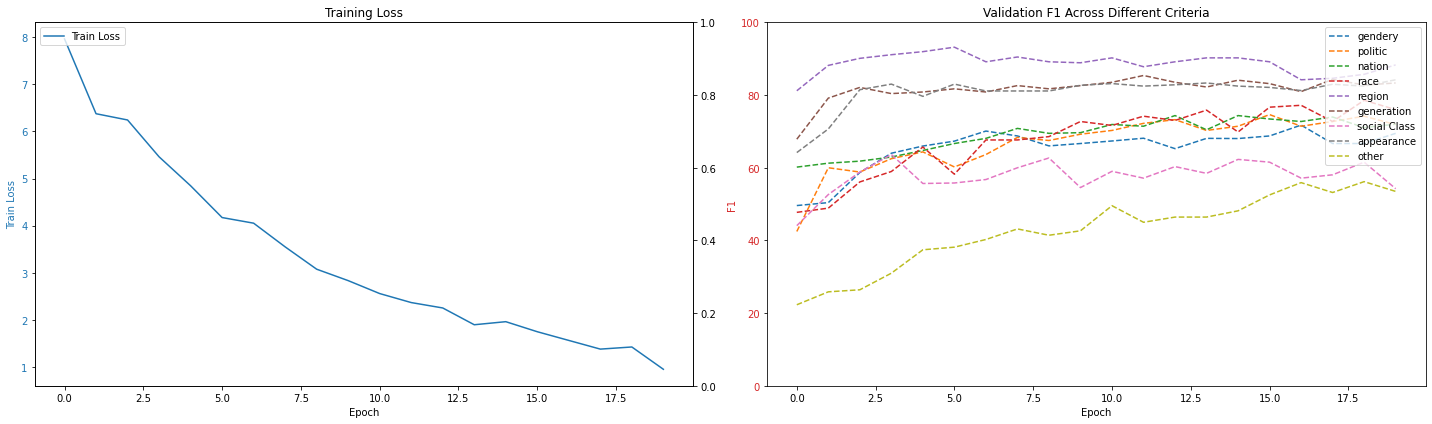

In [25]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax3) = plt.subplots(figsize=(20, 6), ncols=2)

# --- Plot Training Losses on the left plot ---
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Training Loss")

# Create a second y-axis for the F1 scores in the left plot (if needed for other metrics)
ax2 = ax1.twinx()  
color = 'tab:red'
# You can plot other metrics here on ax2 if needed

# --- Plot F1 scores on the right plot ---
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1', color=color)
ax3.set_title("Validation F1 Across Different Criteria")

if config.do_eval_during_train:
    # Unzip the val_accuracies list to obtain individual score lists for each evaluation criterion
    val_scores = list(zip(*val_f1))
    labels = [
        "gendery",
        "politic",
        "nation",
        "race",
        "region",
        "generation",
        "social Class",
        "appearance",
        "other"
    ]
    for idx, label in enumerate(labels):
        ax3.plot(val_scores[idx], label=label, linestyle='--')

    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim(0, 100)

# Display the legends
ax1.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()